<a href="https://colab.research.google.com/github/ChinnuMariya/dissertation-big-data-retinopathy-detection/blob/main/aptos_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from pathlib import Path
from PIL import Image
import copy
import torch
import torchvision
from torchvision import transforms, datasets
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import layers
from collections import Counter
from torchvision.datasets import ImageFolder

In [ ]:
# Paths to your dataset
train_dir = r"C:\Users\ANAKHA\Downloads\Aptos1\train_images"

In [ ]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
csv_path =r'C:\Users\ANAKHA\Downloads\Aptos1\train.csv'
img_dir =r'C:\Users\ANAKHA\Downloads\Aptos1\train_images'
output_base = './split_data'

# Load labels
df = pd.read_csv(csv_path)

# Split into train and validation sets (stratified)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

# Function to copy files to appropriate folder
def copy_images(df_subset, subset_name):
    for _, row in df_subset.iterrows():
        label = str(row['diagnosis'])
        filename = row['id_code'] + '.png'
        src_path = os.path.join(img_dir, filename)
        dest_dir = os.path.join(output_base, subset_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy2(src_path, os.path.join(dest_dir, filename))

# Copy images
copy_images(train_df, 'train')
copy_images(val_df, 'val')

print("✅ Done. Training and validation sets created with class folders.")


✅ Done. Training and validation sets created with class folders.


In [ ]:
print(train_df['diagnosis'].value_counts())
print(val_df['diagnosis'].value_counts())


diagnosis
0    1444
2     799
1     296
4     236
3     154
Name: count, dtype: int64
diagnosis
0    361
2    200
1     74
4     59
3     39
Name: count, dtype: int64


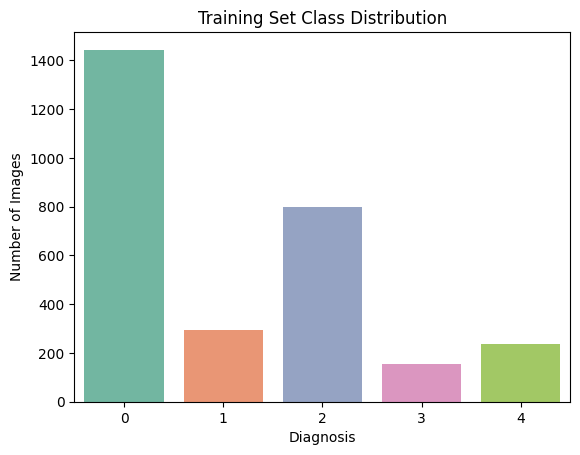

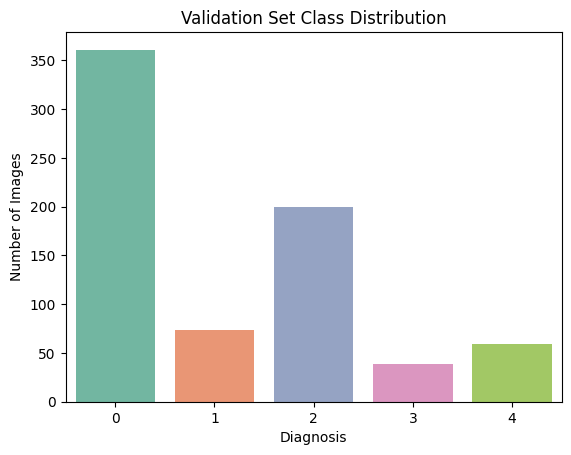

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load your CSV again
df = pd.read_csv(r'C:\Users\ANAKHA\Downloads\Aptos1\train.csv')

# Split as before
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)

# Plot function
def plot_distribution(df, title):
    sns.countplot(data=df, x='diagnosis', palette='Set2')
    plt.title(title)
    plt.xlabel('Diagnosis')
    plt.ylabel('Number of Images')
    plt.show()

# Show distribution
plot_distribution(train_df, 'Training Set Class Distribution')
plot_distribution(val_df, 'Validation Set Class Distribution')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    r'C:\Users\ANAKHA\Downloads\Aptos1\split_data\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    r'C:\Users\ANAKHA\Downloads\Aptos1\split_data\val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


In [ ]:
import random
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  r'C:\Users\ANAKHA\Downloads\Aptos1\split_data\train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2929 files belonging to 5 classes.
Using 2344 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  r'C:\Users\ANAKHA\Downloads\Aptos1\split_data\val',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 733 files belonging to 5 classes.
Using 587 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['0', '1', '2', '3', '4']


In [ ]:
from pathlib import Path

s_train = Path(r"C:\Users\ANAKHA\Downloads\Aptos1\split_data\train")


In [ ]:
from pathlib import Path

s_train = Path(r"C:\Users\ANAKHA\Downloads\Aptos1\split_data\train")

print("Classes found:", [f.name for f in s_train.iterdir() if f.is_dir()])

for class_dir in s_train.iterdir():
    if class_dir.is_dir():
        print(f"Class '{class_dir.name}' contains {len(list(class_dir.glob('*')))} files")


Classes found: ['0', '1', '2', '3', '4']
Class '0' contains 1444 files
Class '1' contains 296 files
Class '2' contains 799 files
Class '3' contains 154 files
Class '4' contains 236 files


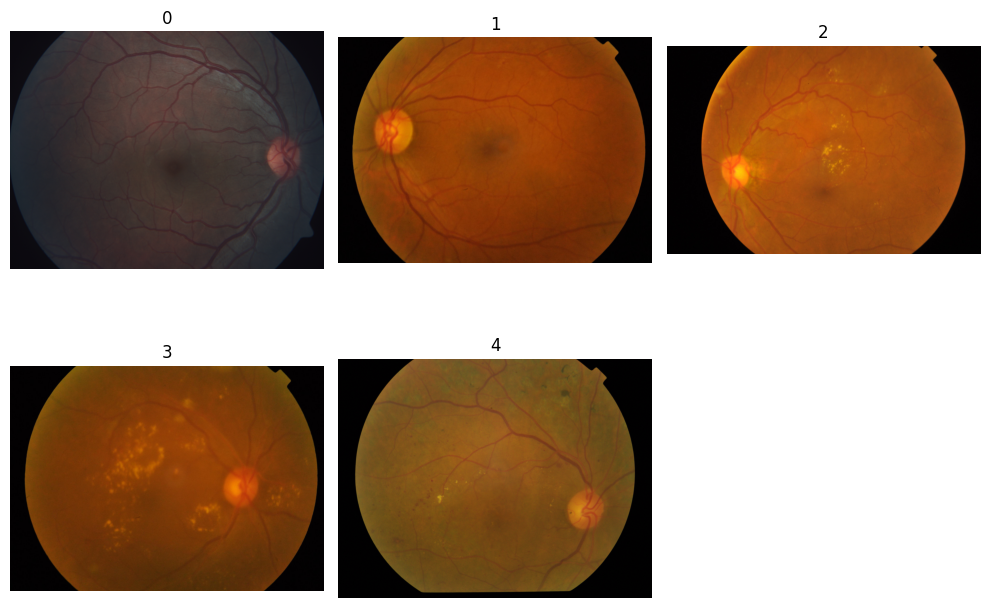

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path
import itertools

image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

num_classes = len(class_names)
plt.figure(figsize=(10, 10))

for i in range(num_classes):
    plt.subplot(3, 3, i + 1)

    # Gather images with multiple extensions
    image_paths = list(itertools.chain.from_iterable(
        s_train .glob(f"{class_names[i]}/{ext}") for ext in image_extensions
    ))

    if len(image_paths) == 0:
        print(f"No images found for class {class_names[i]}")
        continue

    image_path = image_paths[1] if len(image_paths) > 1 else image_paths[0]
    image = img.imread(str(image_path))

    plt.title(class_names[i])
    plt.axis('off')
    plt.imshow(image)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=s_train,          # path to training folder with subfolders for classes
    labels='inferred',            # infer labels from folder names
    label_mode='int',             # integer labels (default)
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)  # e.g., (32, img_height, img_width, 3)
    print(labels_batch.shape) # e.g., (32,)


Found 2929 files belonging to 5 classes.
Using 2344 files for training.
(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling

num_classes = 5

model = Sequential()

model.add(Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,681,925 (56.01 MB)

 Trainable params: 14,681,925 (56.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 319ms/step - accuracy: 0.4725 - loss: 1.3628 - val_accuracy: 0.6917 - val_loss: 0.8960
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.6683 - loss: 0.8634 - val_accuracy: 0.6951 - val_loss: 0.8317
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.7062 - loss: 0.7733 - val_accuracy: 0.6951 - val_loss: 0.9111
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.7152 - loss: 0.8084 - val_accuracy: 0.7070 - val_loss: 0.8531
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.7235 - loss: 0.7540 - val_accuracy: 0.7172 - val_loss: 0.8238
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.7352 - loss: 0.7495 - val_accuracy: 0.7002 - val_loss: 0.8184
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.7476 - loss: 0.7079 - val_accuracy: 0.7104 - val_loss: 0.7874
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.7420 - loss: 0.7140 - val_accu

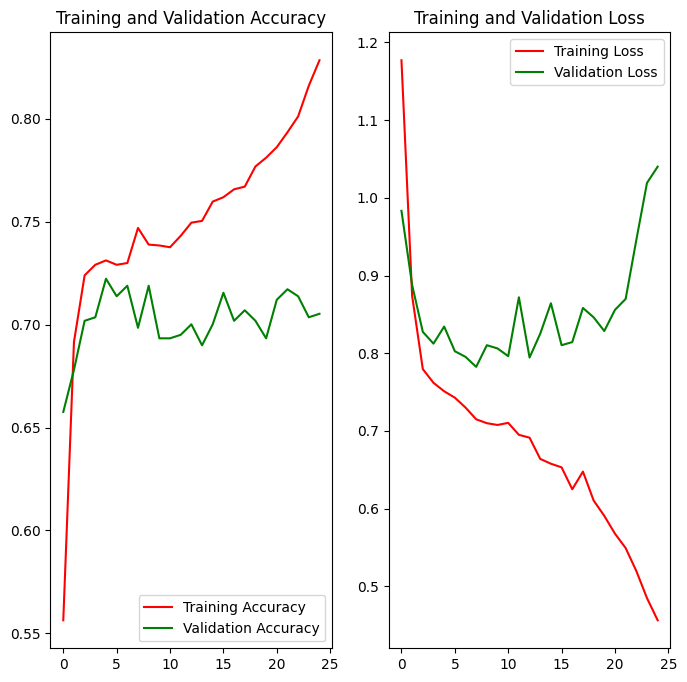

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Model 2 : Data Augumentation with drop out layer.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


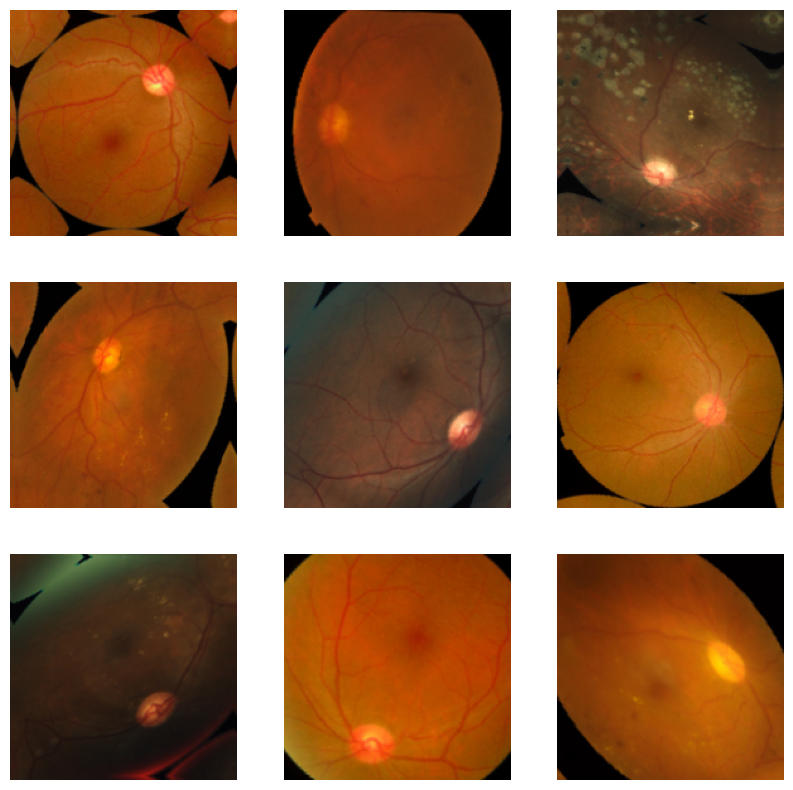

In [ ]:
plt.figure(figsize=(10, 10))

# Get one batch of images from train_ds
for images, _ in train_ds.take(1):
    # Now images is a batch of images

    # Augment the batch once
    augmented_images = data_augmentation(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


In [ ]:
model = Sequential()

model.add(Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,681,925 (56.01 MB)

 Trainable params: 14,681,925 (56.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.4395 - loss: 1.4778 - val_accuracy: 0.6576 - val_loss: 0.9833
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.6969 - loss: 0.8768 - val_accuracy: 0.6780 - val_loss: 0.8877
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.7111 - loss: 0.8063 - val_accuracy: 0.7019 - val_loss: 0.8274
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.7301 - loss: 0.7774 - val_accuracy: 0.7036 - val_loss: 0.8123
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.7203 - loss: 0.7513 - val_accuracy: 0.7223 - val_loss: 0.8343
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.7302 - loss: 0.7354 - val_accuracy: 0.7138 - val_loss: 0.8025
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.7159 - loss: 0.7575 - val_accuracy: 0.7189 - val_loss: 0.7952
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.7425 - loss: 0.7225 - val_accu

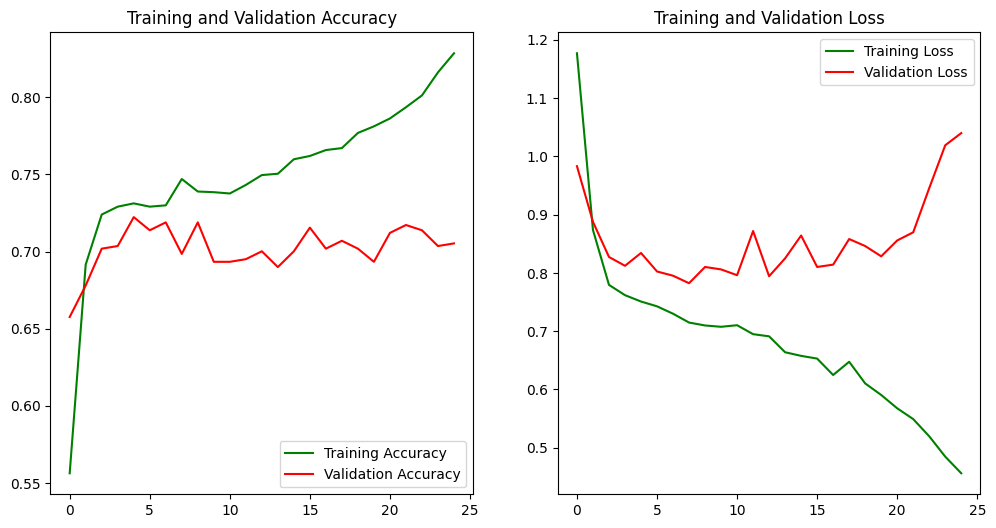

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, color='green', label='Training Accuracy')
plt.plot(epochs_range, val_acc, color='red', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, color='green', label='Training Loss')
plt.plot(epochs_range, val_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Checking and Resolving Class Imbalance

Total training image count = 2929

-------------------------------------
Class name =  0
Count      =  1444
Proportion = 0.4930
-------------------------------------
Class name =  1
Count      =  296
Proportion = 0.1011
-------------------------------------
Class name =  2
Count      =  799
Proportion = 0.2728
-------------------------------------
Class name =  3
Count      =  154
Proportion = 0.0526
-------------------------------------
Class name =  4
Count      =  236
Proportion = 0.0806
-------------------------------------


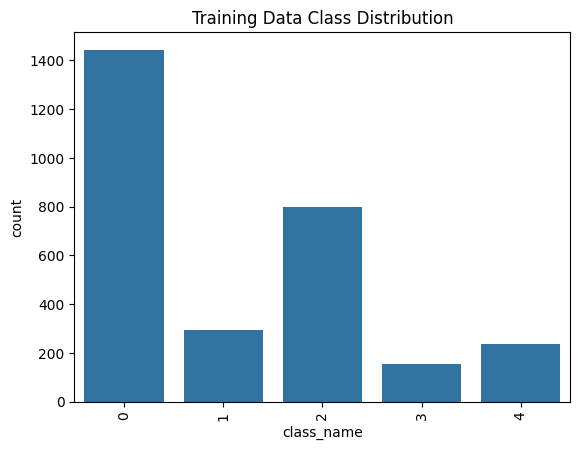

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
    count = len(list(s_train.glob(f"{class_names[i]}/*.png")))
    total += count

print("Total training image count = {}\n".format(total))
print("-------------------------------------")

for i in range(num_classes):
    count = len(list(s_train.glob(f"{class_names[i]}/*.png")))
    proportion = count / total
    print("Class name = ", class_names[i])
    print("Count      = ", count)
    print("Proportion = {:.4f}".format(proportion))
    print("-------------------------------------")
    all_count.append(count)
    class_name.append(class_names[i])

# Plotting the distribution
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns=['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.title("Training Data Class Distribution")
plt.show()


In [ ]:
!pip install Augmentor


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import Augmentor
from pathlib import Path

# Your local training dataset
s_train = Path(r"C:\Users\ANAKHA\Downloads\Aptos1\split_data\train")
output_base_path = Path(r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output")

# List of class names (e.g., ['0', '1', '2', '3', '4'])
class_names = [folder.name for folder in s_train.iterdir() if folder.is_dir()]

# Loop over each class and apply augmentation
for class_name in class_names:
    input_dir = str(s_train / class_name)
    output_dir = str(output_base_path / class_name / "output")

    # Create pipeline
    p = Augmentor.Pipeline(source_directory=input_dir, output_directory=output_dir)

    # Apply rotation like your original code
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Sample 1000 images
    p.sample(1000)

    print(f"Augmented 1000 images for class '{class_name}' into: {output_dir}")


Initialised with 1444 image(s) found.
Output directory set to C:\Users\ANAKHA\Downloads\Aptos1\aug_output\0\output.

Processing <PIL.Image.Image image mode=RGB size=1050x1050 at 0x16D3E2EBF10>: 100%|██████████| 1000/1000 [00:31<00:00, 31.65 Samples/s]               


Augmented 1000 images for class '0' into: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\0\output
Initialised with 296 image(s) found.
Output directory set to C:\Users\ANAKHA\Downloads\Aptos1\aug_output\1\output.

Processing <PIL.Image.Image image mode=RGB size=2416x1736 at 0x16D38BB87C0>: 100%|██████████| 1000/1000 [01:17<00:00, 12.83 Samples/s]               


Augmented 1000 images for class '1' into: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\1\output
Initialised with 799 image(s) found.
Output directory set to C:\Users\ANAKHA\Downloads\Aptos1\aug_output\2\output.

Processing <PIL.Image.Image image mode=RGB size=3216x2136 at 0x16D3E30FEE0>: 100%|██████████| 1000/1000 [01:21<00:00, 12.30 Samples/s]               


Augmented 1000 images for class '2' into: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\2\output
Initialised with 154 image(s) found.
Output directory set to C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output.

Processing <PIL.Image.Image image mode=RGB size=2896x1944 at 0x16D38B73370>: 100%|██████████| 1000/1000 [01:19<00:00, 12.58 Samples/s]               


Augmented 1000 images for class '3' into: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output
Initialised with 236 image(s) found.
Output directory set to C:\Users\ANAKHA\Downloads\Aptos1\aug_output\4\output.

Processing <PIL.Image.Image image mode=RGB size=1844x1226 at 0x16D38AF8160>: 100%|██████████| 1000/1000 [01:30<00:00, 11.10 Samples/s]               

Augmented 1000 images for class '4' into: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\4\output


Total training image count = 5000

-------------------------------------
Class name = 0
Count      = 1000
Proportion = 0.2000
-------------------------------------
Class name = 1
Count      = 1000
Proportion = 0.2000
-------------------------------------
Class name = 2
Count      = 1000
Proportion = 0.2000
-------------------------------------
Class name = 3
Count      = 1000
Proportion = 0.2000
-------------------------------------
Class name = 4
Count      = 1000
Proportion = 0.2000
-------------------------------------


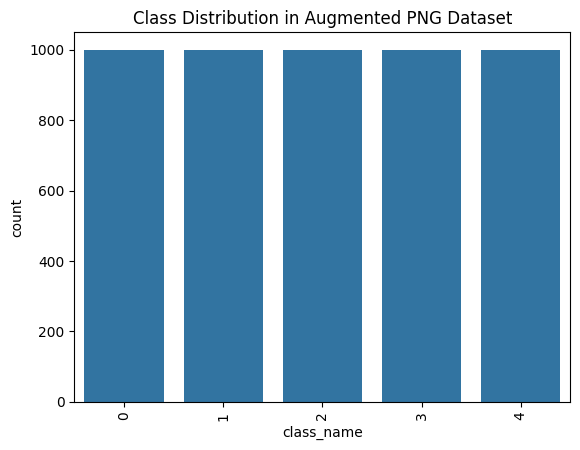

In [ ]:
# List your class names (folder names like '0', '1', etc.)
class_names = sorted([folder.name for folder in output_base_path.iterdir() if folder.is_dir()])
num_classes = len(class_names)

total = 0
all_count = []
class_name = []

# Count .png images in each class folder
for class_id in class_names:
    count = len(list((output_base_path / class_id / 'output').glob('*.png')))
    total += count
    all_count.append(count)
    class_name.append(class_id)

# Print summary
print(f"Total training image count = {total}\n")
print("-------------------------------------")
for i in range(num_classes):
    proportion = all_count[i] / total if total > 0 else 0
    print(f"Class name = {class_name[i]}")
    print(f"Count      = {all_count[i]}")
    print(f"Proportion = {proportion:.4f}")
    print("-------------------------------------")

# Create DataFrame and plot
temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns=['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.title("Class Distribution in Augmented PNG Dataset")
plt.show()

# Modelining Balance Data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_base_path,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5000 files belonging to 5 classes.
Using 4000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_base_path,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


In [ ]:
print(train_ds.class_names)

['0', '1', '2', '3', '4']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Rescaling

num_classes = 5

model = Sequential()

model.add(Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(num_classes, activation='softmax'))


In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,681,925 (56.01 MB)

 Trainable params: 14,681,925 (56.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.2266 - loss: 1.6553 - val_accuracy: 0.4100 - val_loss: 1.3641
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 440ms/step - accuracy: 0.4453 - loss: 1.2689 - val_accuracy: 0.4930 - val_loss: 1.1876
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 490ms/step - accuracy: 0.5419 - loss: 1.1181 - val_accuracy: 0.5790 - val_loss: 1.0271
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 520ms/step - accuracy: 0.6056 - loss: 0.9846 - val_accuracy: 0.6430 - val_loss: 0.8859
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 512ms/step - accuracy: 0.6867 - loss: 0.8060 - val_accuracy: 0.6900 - val_loss: 0.8249
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 532ms/step - accuracy: 0.7363 - loss: 0.6798 - val_accuracy: 0.7350 - val_loss: 0.7279
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 548ms/step - accuracy: 0.7945 - loss: 0.5384 - val_accuracy: 0.7730 - val_loss: 0.6701
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 563ms/step - accuracy: 0.8535 - loss: 0

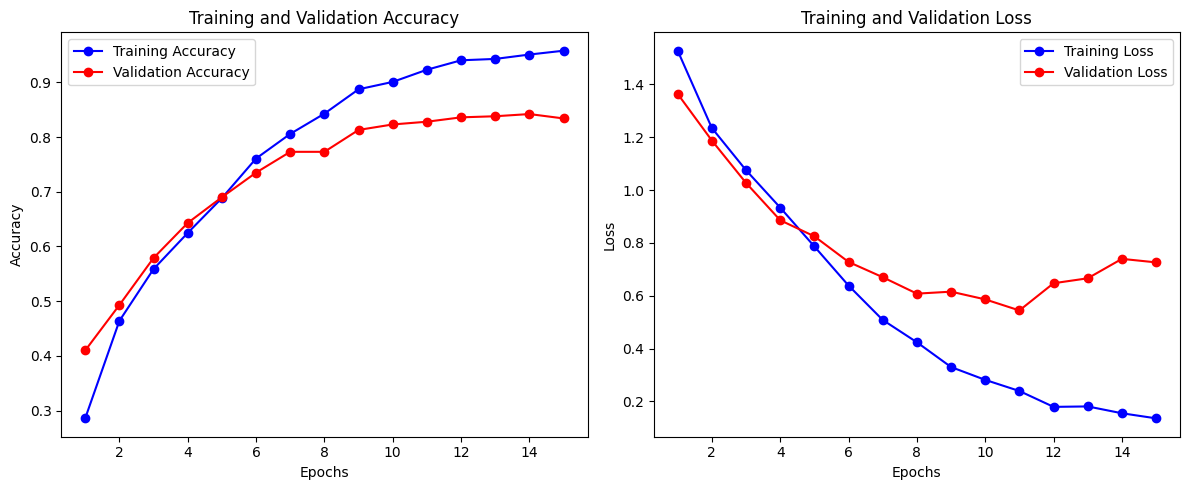

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step
Validation Accuracy: 0.8280
Validation Precision: 0.8266
Validation Recall: 0.8280
Validation F1-score: 0.8265


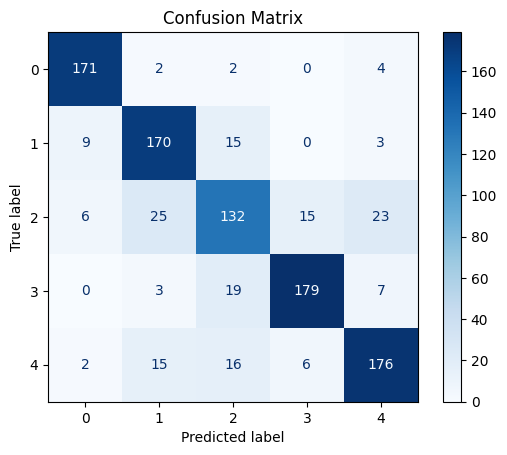

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Extract all validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Step 2: Predict on validation images
y_pred_probs = model.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# y_true is val_labels as integers
y_true = val_labels

# Step 3: Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation F1-score: {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## InceptionResNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam

# Parameters
num_classes = 5
img_height = 180
img_width = 180
batch_size = 32
epochs = 15


# Load InceptionResNetV2 base model (no top), pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                              input_shape=(img_height, img_width, 3))

# Freeze base model layers initially
base_model.trainable = False

# Data augmentation (updated for TF 2.6+)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Build the model
model_1=Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model_1.compile(
     optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

# Train the model with frozen base
history_1  = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Fine-tuning: unfreeze some layers of base model
base_model.trainable = True

# Freeze all layers before a certain point (e.g. first 100 layers)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile with lower learning rate for fine-tuning
model_1.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])



Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.3341 - loss: 2.3332 - val_accuracy: 0.4440 - val_loss: 1.2707
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.4589 - loss: 1.2575 - val_accuracy: 0.5110 - val_loss: 1.1659
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5093 - loss: 1.1506 - val_accuracy: 0.4800 - val_loss: 1.1907
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5052 - loss: 1.1660 - val_accuracy: 0.4610 - val_loss: 1.2615
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4879 - loss: 1.1824 - val_accuracy: 0.5390 - val_loss: 1.0727
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5257 - loss: 1.1165 - val_accuracy: 0.5410 - val_loss: 1.0785
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5304 - loss: 1.0930 - val_accuracy: 0.5220 - val_loss: 1.1808
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5329 - loss: 1.0931 - val_accu

In [ ]:
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs

history_fine_1=model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_1.epoch[-1]
)

Epoch 15/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.3795 - loss: 1.3977 - val_accuracy: 0.4930 - val_loss: 1.1584
Epoch 16/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.4729 - loss: 1.2109 - val_accuracy: 0.5210 - val_loss: 1.0785
Epoch 17/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.5351 - loss: 1.1067 - val_accuracy: 0.5520 - val_loss: 1.0217
Epoch 18/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5682 - loss: 1.0243 - val_accuracy: 0.5930 - val_loss: 0.9762
Epoch 19/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.5902 - loss: 0.9717 - val_accuracy: 0.6150 - val_loss: 0.9228
Epoch 20/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6266 - loss: 0.8870 - val_accuracy: 0.6150 - val_loss: 0.8926
Epoch 21/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.6429 - loss: 0.8613 - val_accuracy: 0.6400 - val_loss: 0.8650
Epoch 22/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.6606 - loss: 0.8449 - 

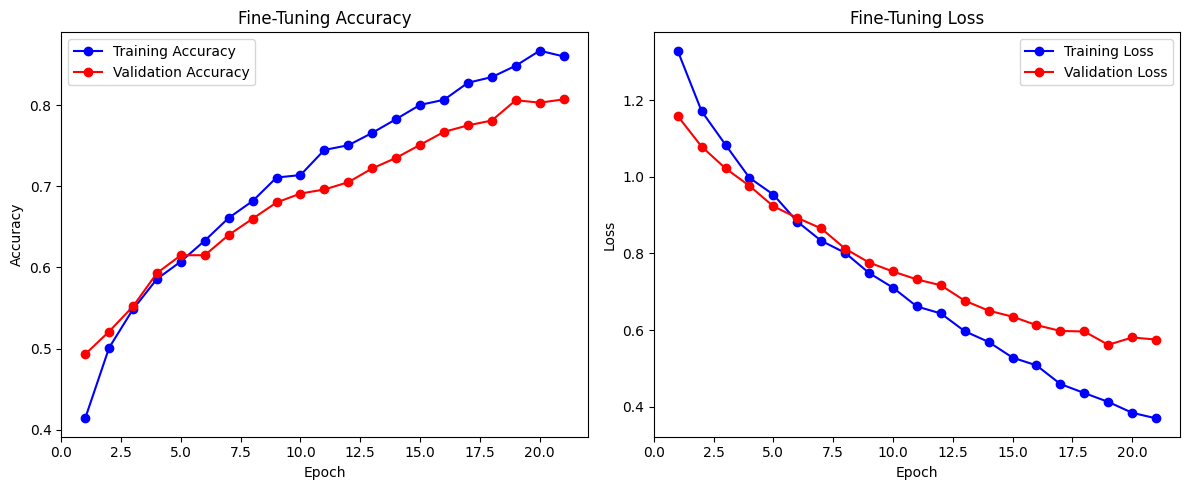

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from the fine-tuning history
acc = history_fine_1.history['accuracy']
val_acc = history_fine_1.history['val_accuracy']
loss = history_fine_1.history['loss']
val_loss = history_fine_1.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 658ms/step
Validation Accuracy: 0.8070
Validation Precision: 0.8068
Validation Recall: 0.8070
Validation F1-score: 0.7960


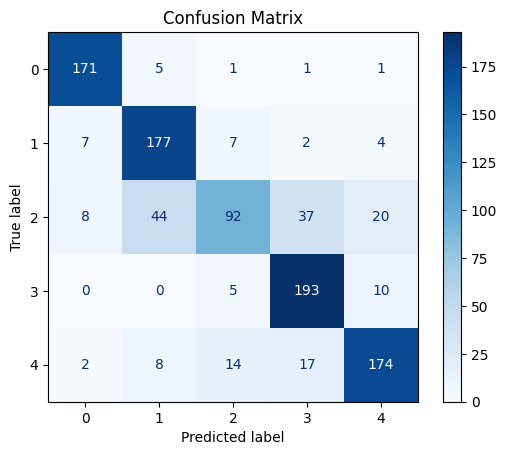

In [ ]:
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Step 2: Predict on validation images
y_pred_probs = model_1.predict(val_images)  # use model_1 here
y_pred = np.argmax(y_pred_probs, axis=1)

# y_true is val_labels as integers
y_true = val_labels

# Step 3: Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation F1-score: {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_prepare_image(img_path, img_height=180, img_width=180):
    img = image.load_img(img_path, target_size=(img_height, img_width))  # Resize
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # No need to rescale here because your model has Rescaling layer
    return img_array


In [ ]:
img_path =r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\4\output\4_original_3ee4841936ef.png_e68650ba-4b8d-4104-9cc8-ab44fc40ef60.png"
img = load_and_prepare_image(img_path)

predictions = model_1.predict(img)  # model_1 is your trained model
predicted_class_index = np.argmax(predictions, axis=1)[0]

print(f"Predicted class index: {predicted_class_index}")
# If you have class names, map the index back:
class_names = train_ds.class_names  # Or your own list of class names
print(f"Predicted class label: {class_names[predicted_class_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted class index: 4
Predicted class label: 4


## Xception

In [ ]:

from tensorflow.keras.applications import Xception

# Parameters
num_classes = 5
img_height = 180
img_width = 180
epochs_initial = 15
epochs_finetune = 20

# Load Xception base model (exclude top)
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # Freeze the base model initially

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Build the full model
model_x = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model for initial training
model_x.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train with frozen base
history_x = model_x.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial
)

# Fine-tuning
base_model.trainable = True

# Optionally, freeze the earlier layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compile again with a lower learning rate
model_x.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 829ms/step - accuracy: 0.4138 - loss: 1.5595 - val_accuracy: 0.5460 - val_loss: 1.0905
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 832ms/step - accuracy: 0.5409 - loss: 1.0618 - val_accuracy: 0.5120 - val_loss: 1.1290
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 854ms/step - accuracy: 0.5703 - loss: 1.0166 - val_accuracy: 0.5680 - val_loss: 1.0164
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 873ms/step - accuracy: 0.5944 - loss: 0.9647 - val_accuracy: 0.5830 - val_loss: 0.9779
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 885ms/step - accuracy: 0.6106 - loss: 0.9510 - val_accuracy: 0.5720 - val_loss: 0.9666
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 851ms/step - accuracy: 0.6327 - loss: 0.9026 - val_accuracy: 0.6100 - val_loss: 0.9354
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 827ms/step - accuracy: 0.6521 - loss: 0.8714 - val_accuracy: 0.5970 - val_loss: 0.9652
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 823ms/step - accuracy: 0.6500 -

In [ ]:
# Continue training for more epochs
fine_tune_epochs = 20
total_epochs = epochs_initial + fine_tune_epochs

history_fine_x = model_x.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,           # <-- corrected here
    initial_epoch=history_x.epoch[-1]
)


Epoch 15/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.4332 - loss: 1.3308 - val_accuracy: 0.5590 - val_loss: 1.1514
Epoch 16/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5803 - loss: 1.0435 - val_accuracy: 0.5950 - val_loss: 0.9935
Epoch 17/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6112 - loss: 0.9562 - val_accuracy: 0.6170 - val_loss: 0.8961
Epoch 18/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6476 - loss: 0.9064 - val_accuracy: 0.6210 - val_loss: 0.8610
Epoch 19/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6524 - loss: 0.8541 - val_accuracy: 0.6470 - val_loss: 0.8323
Epoch 20/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6790 - loss: 0.8082 - val_accuracy: 0.6470 - val_loss: 0.8219
Epoch 21/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7013 - loss: 0.7589 - val_accuracy: 0.6650 - val_loss: 0.7964
Epoch 22/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7038 - loss: 0.7479 - 

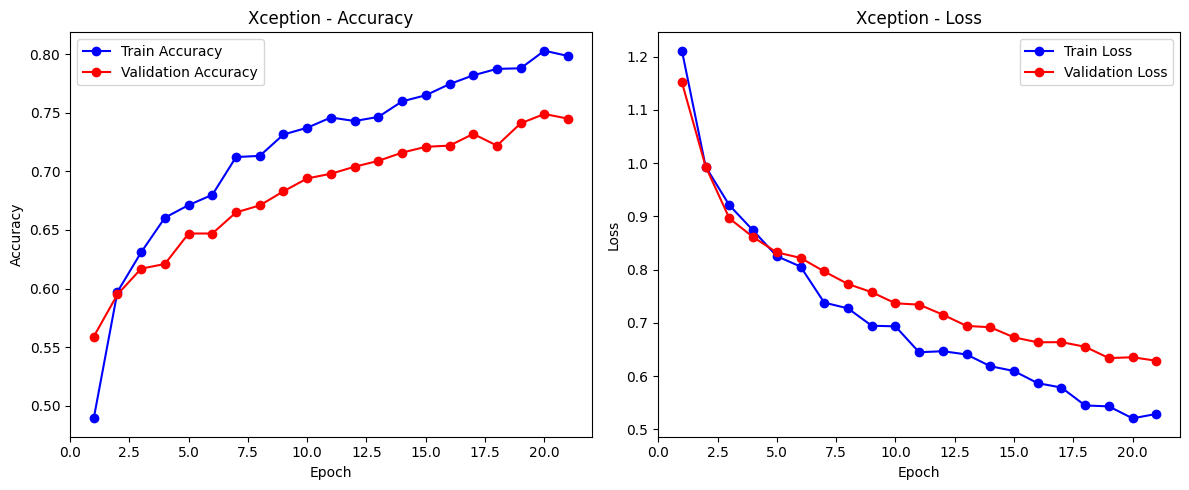

In [ ]:
acc = history_fine_x.history['accuracy']
val_acc = history_fine_x.history['val_accuracy']
loss = history_fine_x.history['loss']
val_loss = history_fine_x.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Xception - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Train Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Xception - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get predictions
y_pred_probs = model_x.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 718ms/step


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 671ms/step
Validation Accuracy: 0.7450
Validation Precision: 0.7421
Validation Recall: 0.7450
Validation F1-score: 0.7380


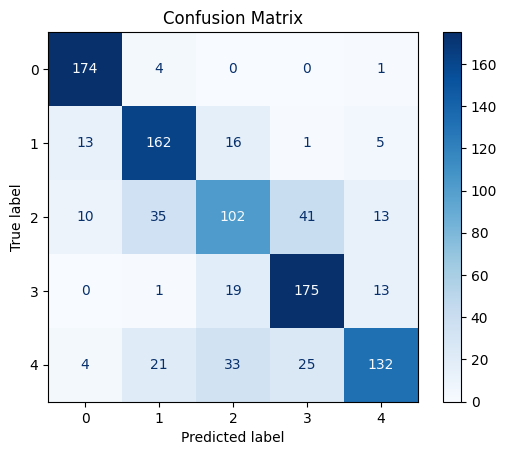

In [ ]:
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Step 2: Predict on validation images
y_pred_probs = model_x.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# y_true is val_labels as integers
y_true = val_labels

# Step 3: Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation F1-score: {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.applications import DenseNet201


# Parameters
num_classes = 5
img_height = 180
img_width = 180
epochs_initial = 15
epochs_finetune = 20

# Load Xception base model (exclude top)
base_model = DenseNet201(weights='imagenet',
                         include_top=False,
                         input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model initially

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Build the full model
model_d= Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model for initial training
model_d.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train with frozen base
history_d=model_d.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_initial
)

# Fine-tuning
base_model.trainable = True

# Optionally, freeze the earlier layers
for layer in base_model.layers[:100]:
    layer.trainable = False





Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.4156 - loss: 1.5349 - val_accuracy: 0.5600 - val_loss: 1.0293
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5349 - loss: 1.1002 - val_accuracy: 0.5820 - val_loss: 0.9927
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5487 - loss: 1.0688 - val_accuracy: 0.6080 - val_loss: 0.9664
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5882 - loss: 1.0029 - val_accuracy: 0.5930 - val_loss: 0.9479
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5809 - loss: 0.9880 - val_accuracy: 0.5870 - val_loss: 0.9554
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5876 - loss: 0.9667 - val_accuracy: 0.5970 - val_loss: 0.9358
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5981 - loss: 0.9428 - val_accuracy: 0.6060 - val_loss: 0.9239
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 970ms/step - accuracy: 0.6220 - loss: 0.9063 - val_a

In [ ]:
# Compile again with a lower learning rate
model_d.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
# Continue training for more epochs
fine_tune_epochs = 15
total_epochs =epochs_initial+ fine_tune_epochs

history_fine_d=model_d.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_d.epoch[-1]
)

Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.4229 - loss: 1.7300 - val_accuracy: 0.6240 - val_loss: 0.9484
Epoch 16/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - accuracy: 0.5357 - loss: 1.2303 - val_accuracy: 0.6550 - val_loss: 0.8687
Epoch 17/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.6014 - loss: 1.0026 - val_accuracy: 0.6630 - val_loss: 0.8346
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.6441 - loss: 0.9109 - val_accuracy: 0.6830 - val_loss: 0.8102
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.6660 - loss: 0.8324 - val_accuracy: 0.7030 - val_loss: 0.7517
Epoch 20/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.6845 - loss: 0.7979 - val_accuracy: 0.7190 - val_loss: 0.7240
Epoch 21/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.7196 - loss: 0.7107 - val_accuracy: 0.7210 - val_loss: 0.7116
Epoch 22/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.7202 - loss: 0.6801 - 

In [ ]:
# Continue training for more epochs
more_epochs = 10
new_total_epochs = total_epochs + more_epochs  # from your last total_epochs (30)

history_more_d=model_d.fit(
    train_ds,
    validation_data=val_ds,
    epochs=new_total_epochs,          # e.g., 40
    initial_epoch=history_fine_d.epoch[-1]  # start from last epoch (e.g., 30)
)


Epoch 30/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.8461 - loss: 0.4057 - val_accuracy: 0.8310 - val_loss: 0.4737
Epoch 31/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.8540 - loss: 0.3820 - val_accuracy: 0.8290 - val_loss: 0.4717
Epoch 32/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8743 - loss: 0.3504 - val_accuracy: 0.8420 - val_loss: 0.4591
Epoch 33/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.8754 - loss: 0.3347 - val_accuracy: 0.8480 - val_loss: 0.4387
Epoch 34/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.8873 - loss: 0.3025 - val_accuracy: 0.8370 - val_loss: 0.4527
Epoch 35/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.8742 - loss: 0.3195 - val_accuracy: 0.8420 - val_loss: 0.4584
Epoch 36/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 386s 3s/step - accuracy: 0.8975 - loss: 0.2914 - val_accuracy: 0.8490 - val_loss: 0.4215
Epoch 37/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.9069 - loss: 0.2807 - 

In [ ]:
# Optional: Combine all histories for plotting
def merge_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
        combined[key] = h1.history[key] + h2.history[key]
    return combined

full_history = merge_histories(history_fine_d, history_more_d)


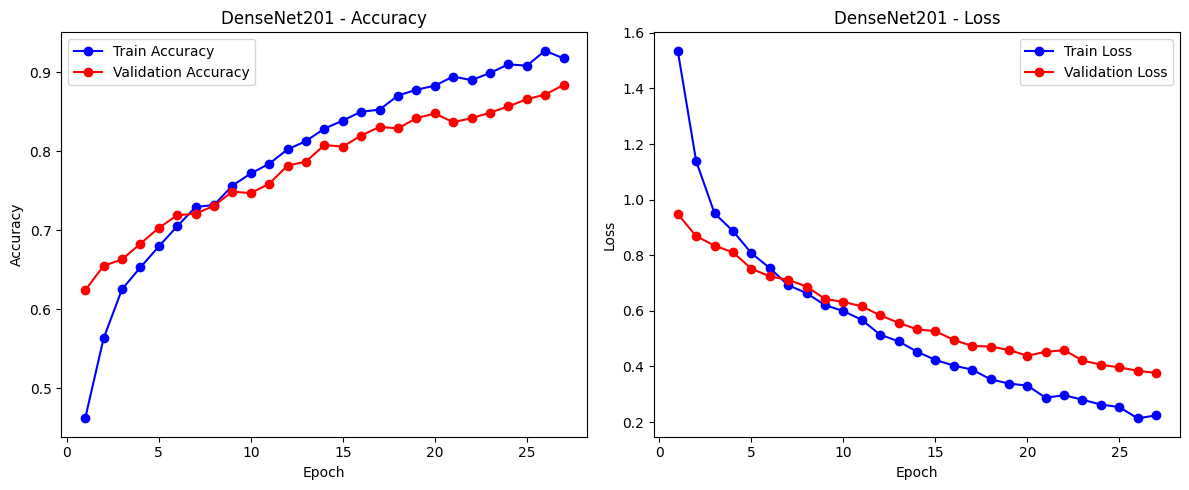

In [ ]:
acc = full_history['accuracy']
val_acc = full_history['val_accuracy']
loss = full_history['loss']
val_loss =full_history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('DenseNet201 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Train Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('DenseNet201 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Get true labels from validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Get predicted probabilities and class indices
y_pred_probs = model_d.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step


In [ ]:
import os
os.makedirs(r"C:\Users\ANAKHA\Downloads\Aptos1\saved_models", exist_ok=True)
model_d.save(r"C:\Users\ANAKHA\Downloads\Aptos1\saved_models\model_d.keras")


In [ ]:
import os
print(os.path.exists(r"C:\Users\ANAKHA\Downloads\Aptos1\saved_models\model_d.keras"))


True


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 903ms/step
 Validation Accuracy:  0.8840
 Validation Precision: 0.8879
 Validation Recall:    0.8840
 Validation F1-score:  0.8796


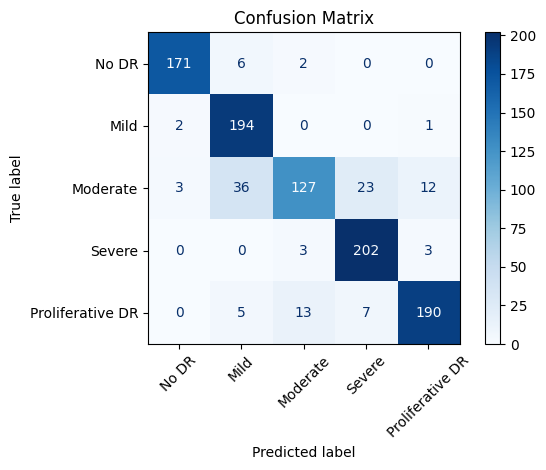

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Step 1: Extract validation images and labels
val_images = []
val_labels = []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Step 2: Predict on validation images
y_pred_probs = model_d.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_labels

# Step 3: Calculate evaluation metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f" Validation Accuracy:  {acc:.4f}")
print(f" Validation Precision: {prec:.4f}")
print(f" Validation Recall:    {rec:.4f}")
print(f" Validation F1-score:  {f1:.4f}")

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
models_info = []

# Custom CNN
y_pred = np.argmax(model.predict(val_images), axis=1)
acc = accuracy_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred, average='weighted')
models_info.append({"name": "Custom CNN", "model": model, "accuracy": acc, "f1_score": f1})

# InceptionResNetV2
y_pred = np.argmax(model_1.predict(val_images), axis=1)
acc = accuracy_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred, average='weighted')
models_info.append({"name": "InceptionResNetV2", "model": model_1, "accuracy": acc, "f1_score": f1})

# Xception
y_pred = np.argmax(model_x.predict(val_images), axis=1)
acc = accuracy_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred, average='weighted')
models_info.append({"name": "Xception", "model": model_x, "accuracy": acc, "f1_score": f1})

# DenseNet201
y_pred = np.argmax(model_d.predict(val_images), axis=1)
acc = accuracy_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred, average='weighted')
models_info.append({"name": "DenseNet201", "model": model_d, "accuracy": acc, "f1_score": f1})


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 478ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step


In [ ]:
best_model_info = max(models_info, key=lambda x: x['accuracy'])
best_model_info = max(models_info, key=lambda x: x['f1_score'])
print(f" Best model: {best_model_info['name']} with accuracy: {best_model_info['accuracy']:.4f}")
best_model_info['model'].save("best_model.keras")
print(f"Best model: {best_model_info['name']} with accuracy: {best_model_info['accuracy']:.4f} and weighted F1: {best_model_info['f1_score']:.4f}")

 Best model: DenseNet201 with accuracy: 0.8840
Best model: DenseNet201 with accuracy: 0.8840 and weighted F1: 0.8796


In [ ]:
best_model_info['model'].save("best_model.keras")# Preferred format over HDF5
print(best_model_info)


{'name': 'DenseNet201', 'model': <Sequential name=sequential_14, built=True>, 'accuracy': 0.884, 'f1_score': 0.8795549751439803}


In [ ]:
best_model_info['model'].summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 5, 5, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,815,185 (224.36 MB)

 Trainable params: 19,260,485 (73.47 MB)

 Non-trainable params: 1,033,728 (3.94 MB)

 Optimizer params: 38,520,972 (146.95 MB)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input

def predict_images(image_paths, model, target_size=(180, 180)):
    imgs = []
    for path in image_paths:
        # Load and resize
        img = image.load_img(path, target_size=target_size)
        img_array = image.img_to_array(img)
        imgs.append(img_array)
    # Convert to numpy array and add batch dimension
    imgs = np.array(imgs)

    # Preprocess for DenseNet201
    imgs_preprocessed = preprocess_input(imgs)

    # Predict probabilities
    preds = model.predict(imgs_preprocessed)

    # Convert to class indices
    pred_classes = np.argmax(preds, axis=1)
    return pred_classes


In [ ]:
models_info = [
    {"name": "Custom CNN", "model": model},
    {"name": "InceptionResNetV2", "model": model_1},
    {"name": "Xception", "model": model_x},
    {"name": "DenseNet201", "model": model_d},
]


In [ ]:
image_paths=[r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\2\output\2_original_98f48850ebce.png_f599e595-d677-4f11-b4b1-3f5be48d556d.png", r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\0\output\0_original_3f82631e9080.png_54baa185-7559-4b67-b10b-c02a09ed73ff.png",r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output\3_original_7d3835e4e63a.png_c37322ee-dfca-4e4c-877f-04db766a10fe.png"]


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_prepare_image(img_path, img_height=180, img_width=180):
    img = image.load_img(img_path, target_size=(img_height, img_width))  # Resize
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    # No need to rescale here because your model has Rescaling layer
    return img_array

img_path =r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output\3_original_4df6a81b476e.png_293fe189-9127-4be1-bd3f-4b00500a615b.png"
img = load_and_prepare_image(img_path)

predictions = model_d.predict(img)  # model_1 is your trained model
predicted_class_index = np.argmax(predictions, axis=1)[0]

print(f"Predicted class index: {predicted_class_index}")
# If you have class names, map the index back:
class_names = train_ds.class_names  # Or your own list of class names
print(f"Predicted class label: {class_names[predicted_class_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted class index: 3
Predicted class label: 3


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_and_prepare_images(img_paths, img_height=180, img_width=180):
    imgs = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img_array = image.img_to_array(img)
        imgs.append(img_array)
    imgs = np.array(imgs)
    # No need to rescale if your model has a Rescaling layer
    return imgs

# Example list of image paths
img_paths = [
    r"C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output\3_original_4df6a81b476e.png_293fe189-9127-4be1-bd3f-4b00500a615b.png",
    r"C:\Users\ANAKHA\Downloads\Aptos1\augmented_output\2\output\2_original_aca88f566228.png_f6e65d07-c0f6-4c9c-b903-29d7dc1957fc.png",
    r"C:\Users\ANAKHA\Downloads\Aptos1\augmented_output\1\output\1_original_0a61bddab956.png_8cec13c5-8f8d-499b-be0a-4db12ca6944f.png"
    # add more image paths here
]

imgs = load_and_prepare_images(img_paths)
predictions = model_d.predict(imgs)
predicted_class_indices = np.argmax(predictions, axis=1)

class_names = train_ds.class_names  # or your list of class names

for path, pred_idx in zip(img_paths, predicted_class_indices):
    print(f"Image: {path} => Predicted class index: {pred_idx}, label: {class_names[pred_idx]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
Image: C:\Users\ANAKHA\Downloads\Aptos1\aug_output\3\output\3_original_4df6a81b476e.png_293fe189-9127-4be1-bd3f-4b00500a615b.png => Predicted class index: 3, label: 3
Image: C:\Users\ANAKHA\Downloads\Aptos1\augmented_output\2\output\2_original_aca88f566228.png_f6e65d07-c0f6-4c9c-b903-29d7dc1957fc.png => Predicted class index: 2, label: 2
Image: C:\Users\ANAKHA\Downloads\Aptos1\augmented_output\1\output\1_original_0a61bddab956.png_8cec13c5-8f8d-499b-be0a-4db12ca6944f.png => Predicted class index: 1, label: 1


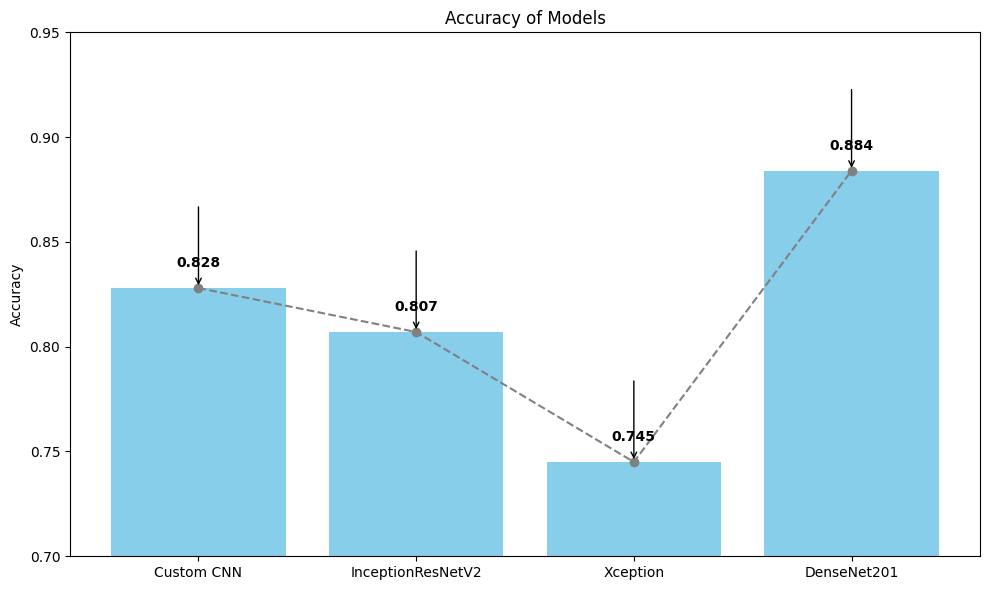

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Custom CNN', 'InceptionResNetV2', 'Xception', 'DenseNet201']
val_acc = [0.828, 0.807, 0.745, 0.884]

# Create figure
plt.figure(figsize=(10, 6))
bars = plt.bar(models, val_acc, color='skyblue')
plt.title('Accuracy of Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.95)

# Add value labels and arrows
for i, v in enumerate(val_acc):
    # Text above bar
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')
    # Arrow pointing to bar top
    plt.annotate('', xy=(i, v), xytext=(i, v + 0.04),
                 arrowprops=dict(arrowstyle='->', color='black'))

# Optional: Line connecting all tops (trend line)
plt.plot(range(len(val_acc)), val_acc, linestyle='--', color='gray', marker='o', markersize=6)

plt.tight_layout()
plt.show()


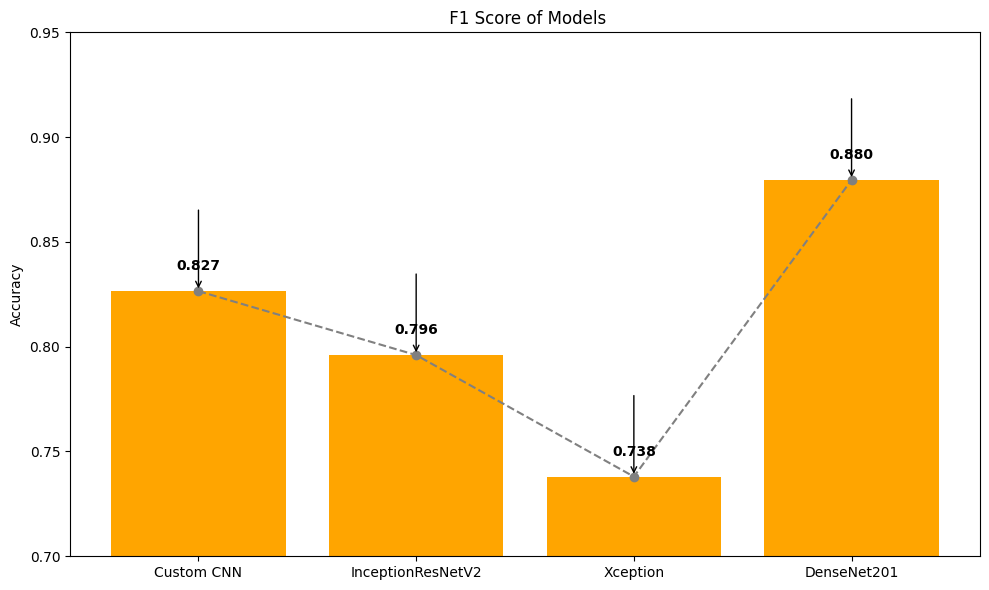

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Custom CNN', 'InceptionResNetV2', 'Xception', 'DenseNet201']
f1_scores = [0.8265, 0.7960, 0.7380, 0.8796]


# Create figure
plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color='orange')
plt.title(' F1 Score of Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.95)

# Add value labels and arrows
for i, v in enumerate(f1_scores):
    # Text above bar
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10, fontweight='bold')
    # Arrow pointing to bar top
    plt.annotate('', xy=(i, v), xytext=(i, v + 0.04),
                 arrowprops=dict(arrowstyle='->', color='black'))

# Optional: Line connecting all tops (trend line)
plt.plot(range(len(f1_scores)), f1_scores, linestyle='--', color='gray', marker='o', markersize=6)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

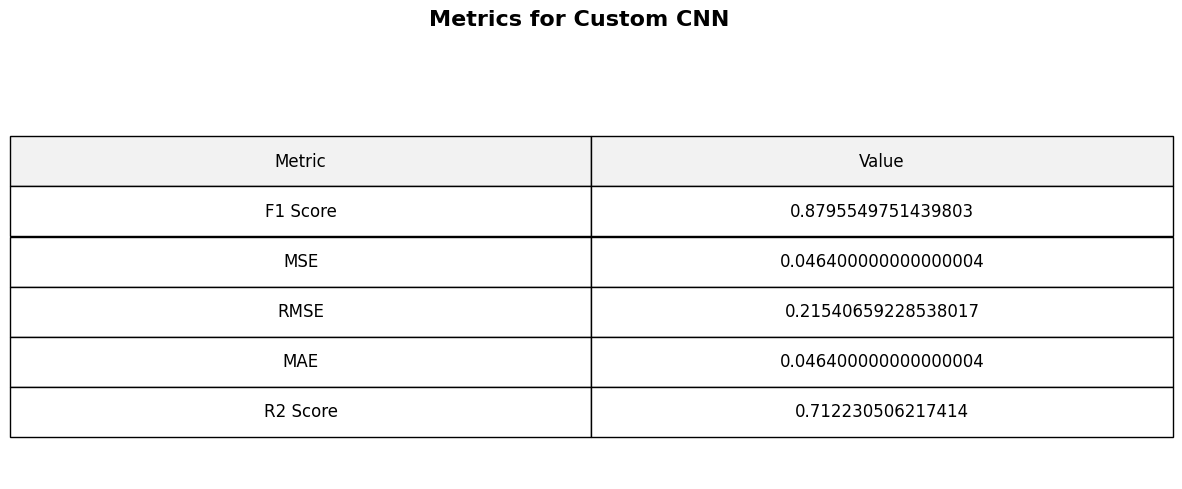

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━

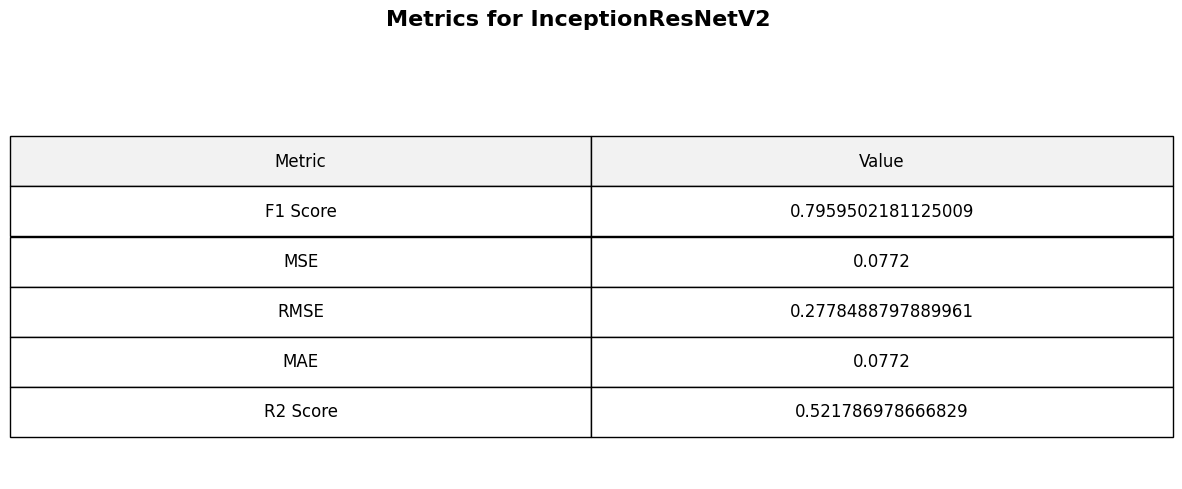

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820

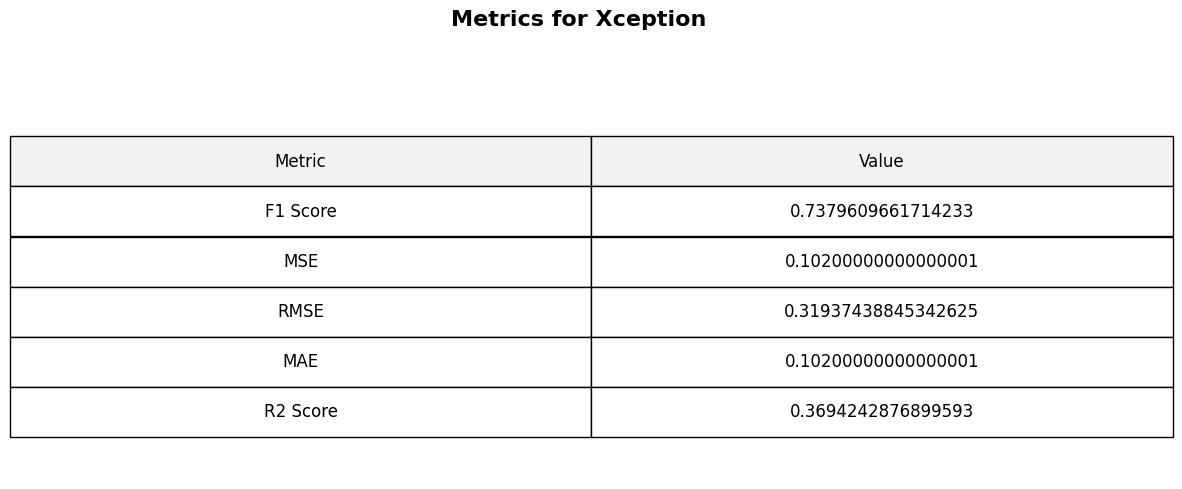

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

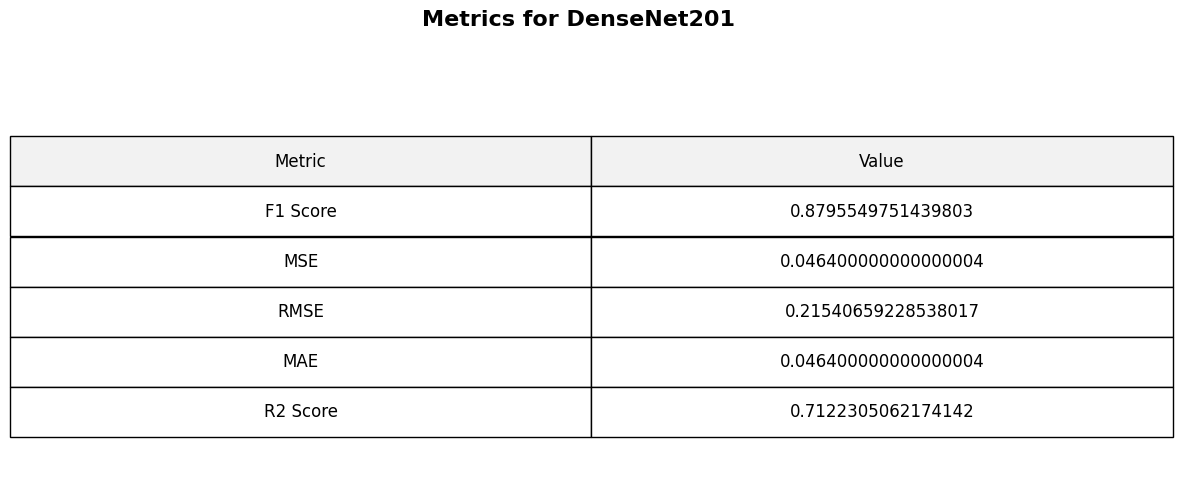

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

num_classes = 5  # Update this as per your problem

def compute_metrics(model, data_loader, num_classes):
    y_true = []
    y_pred = []

    for x, y in data_loader:
        y_true.extend(y.numpy())
        preds = model.predict(x)
        preds_class = np.argmax(preds, axis=1)
        y_pred.extend(preds_class)

    f1 = f1_score(y_true, y_pred, average='weighted')

    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    y_pred_one_hot = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

    mse = mean_squared_error(y_true_one_hot, y_pred_one_hot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_one_hot, y_pred_one_hot)
    r2 = r2_score(y_true_one_hot, y_pred_one_hot)

    return f1, mse, rmse, mae, r2
def plot_metrics_box(model_name, f1, mse, rmse, mae, r2):
    metrics_data = {
        'Metric': ['F1 Score', 'MSE', 'RMSE', 'MAE', 'R2 Score'],
        'Value': [f1, mse, rmse, mae, r2]
    }
    df = pd.DataFrame(metrics_data)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('off')  # Hide axes completely
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center',
        colColours=["#f2f2f2"] * len(df.columns)
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 3)

    plt.suptitle(f"Metrics for {model_name}", fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# Run for each model
for info in models_info:
    f1, mse, rmse, mae, r2 = compute_metrics(info["model"], val_ds, num_classes)
    plot_metrics_box(info["name"], f1, mse, rmse, mae, r2)



In [ ]:
pip install streamlit tensorflow pillow


     ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/9.9 MB 1.3 MB/s eta 0:00:08
      --------------------------------------- 0.2/9.9 MB 2.8 MB/s eta 0:00:04
     -- ------------------------------------- 0.5/9.9 MB 4.2 MB/s eta 0:00:03
     ----- ---------------------------------- 1.3/9.9 MB 7.6 MB/s eta 0:00:02
     ---------- ----------------------------- 2.7/9.9 MB 13.2 MB/s eta 0:00:01
     ------------- -------------------------- 3.3/9.9 MB 15.2 MB/s eta 0:00:01
     ----------------------- ---------------- 5.8/9.9 MB 19.4 MB/s eta 0:00:01
     ---------------------------- ----------- 7.0/9.9 MB 21.3 MB/s eta 0:00:01
     -------------------------------- ------- 7.9/9.9 MB 21.2 MB/s eta 0:00:01
     ------------------------------------ --- 9.0/9.9 MB 22.1 MB/s eta 0:00:01
     ---------------------------------------  9.9/9.9 MB 23.3 MB/s eta 0:00:01
     ---------------------------------------- 9.9/9.9 MB 21.0 MB


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
